In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import config
from Dataset import RefineDataset
from Generator import Refine_Generator
from Discriminator import Refine_Discriminator
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import generate_image
import numpy as np
import cv2
from IPython.display import clear_output, display
from PIL import Image

In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,epoch
):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * config.L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                G_loss=G_loss.item(),
                D_loss=D_loss.item(),
                epoch=epoch
            )

In [4]:
disc = Refine_Discriminator(input_channels=3,features=64).to(config.DEVICE)
gen = Refine_Generator(input_channels=3,output_channels=3, features=64).to(config.DEVICE)

gen.load_state_dict(torch.load(config.REFINE_CHECKPOINT_GEN))
disc.load_state_dict(torch.load(config.REFINE_CHECKPOINT_DISC))

In [ ]:
def generate_img(genrator,img):
    img = img.to(config.DEVICE)
    img = genrator(img)
    img = img.cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = (img * 255).astype(np.uint8)
    return img

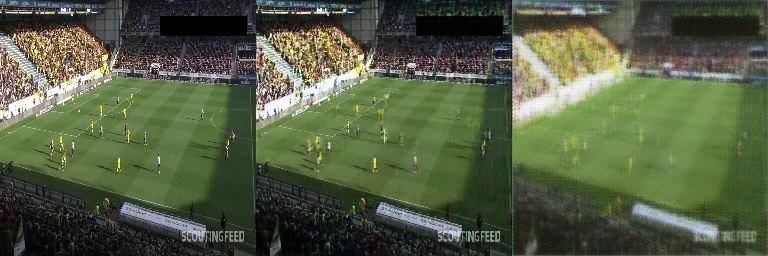

 71%|███████   | 121/170 [03:04<01:25,  1.75s/it, D_loss=0.503, G_loss=5.39, epoch=7]

In [6]:
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(00, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()


train_dataset = RefineDataset(img_paths=config.TRAIN_DIR)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
)

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

best_test_loss_disc = float('inf')
best_test_loss_gen = float('inf')

for epoch in range(config.NUM_EPOCHS):
    train_fn(
        disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,epoch
    )
    
    torch.save(disc.state_dict(), config.REFINE_CHECKPOINT_DISC)
    torch.save(gen.state_dict(), config.REFINE_CHECKPOINT_GEN)
    img = cv2.imread("dataset/refine/train/0.jpg")
    input_img = img[:,256:]
    out = generate_image(gen,input_img)
    comp = np.concatenate([img,out],1)
    clear_output(wait=True)
    display(Image.fromarray(comp))


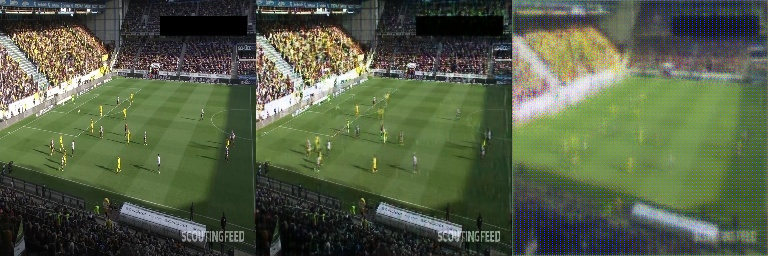

In [ ]:
img = cv2.imread("dataset/refine/train/0.jpg")
input_img = img[:,256:]
out = generate_image(gen,input_img)
comp = np.concatenate([img,out],1)
clear_output(wait=True)
display(Image.fromarray(comp))